# Titanic - Machine Learning from Disaster

In [164]:
import numpy as np

# Funcions i paquets per a visualitzacio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Paquet per a manipulacio de dades
import pandas as pd

# Funcions i paquets per a carregar datasets especifics (exemples simples)
from sklearn import datasets

# Funcions per a processat de dades
from sklearn.preprocessing import StandardScaler
# Funcions per a partició de dades
from sklearn.model_selection import train_test_split
# Funcions per a classificacio kNN
from sklearn.neighbors import KNeighborsClassifier
# Funcions per a metriques de rendiment
from sklearn.metrics import accuracy_score,  precision_score, recall_score, roc_curve,roc_auc_score, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

#funcions per a la validació creuada
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

Carreguem la base de dades

In [165]:
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##### Check basic info about the data set including missing value.

In [166]:
t=train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [167]:
d = train.describe()
d

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Exploratory analysis and plots

**Plot a bar diagram to check the number of numeric entries**

From the bar diagram, it shows that there are some age entries missing as the number of count for 'Age' is less than the other counts. We can do some impute/transformation of the data to fill-up the missing entries.

Text(0.5, 1.0, 'Bar plot of the count of numeric features')

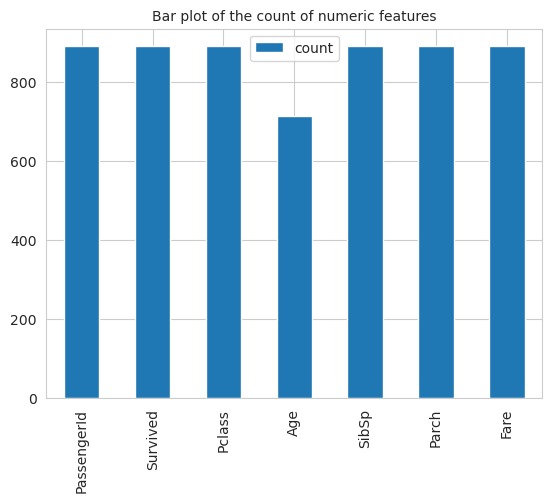

In [168]:
dT=d.T
dT.plot.bar(y='count')
plt.title("Bar plot of the count of numeric features",fontsize=10)

Check the relative size of survived and not-survived.

<Axes: xlabel='Survived', ylabel='count'>

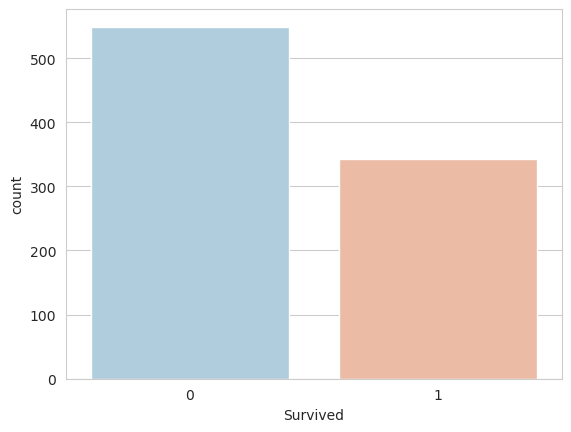

In [169]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', data=train, palette='RdBu_r')

**Is there a pattern for the survivability based on sex?**

It looks like more female survived than males!

<Axes: xlabel='Survived', ylabel='count'>

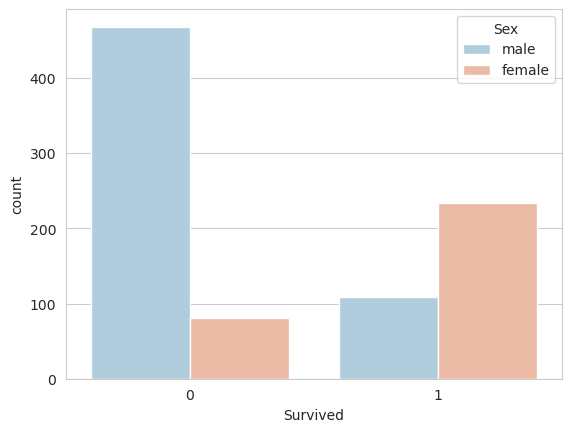

In [170]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

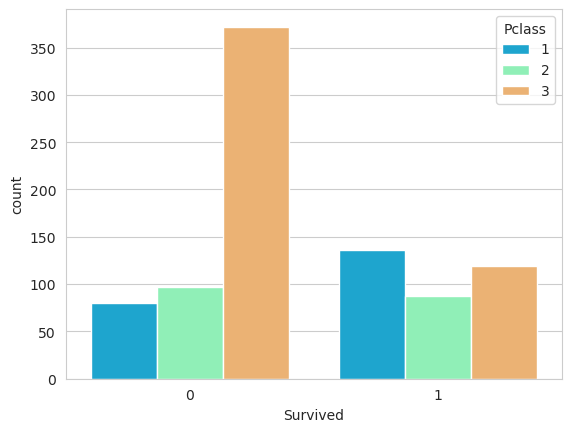

In [171]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

**Following code extracts and plots the fraction of passenger count that survived, by each class**

Text(0.5, 1.0, 'Fraction of passengers survived by class')

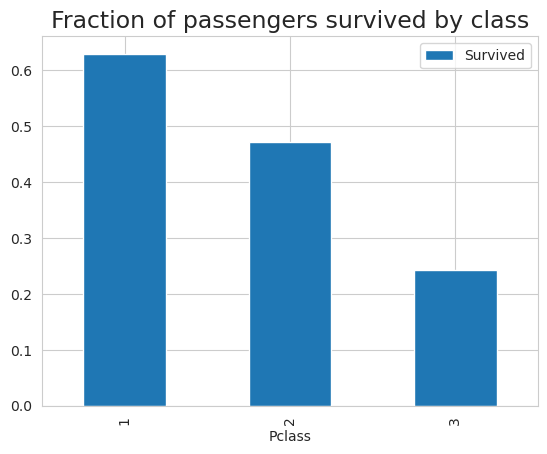

In [172]:
train['Survived'] = train['Survived'].astype(float)
f_class_survived = train.groupby('Pclass')['Survived'].mean()
f_class_survived = pd.DataFrame(f_class_survived)
f_class_survived.plot.bar(y='Survived')
plt.title("Fraction of passengers survived by class",fontsize=17)

**What about any pattern related to having sibling and spouse?**

It looks like there is a weak trend that chance of survibility increased if there were more number of sibling or spouse.

<Axes: xlabel='Survived', ylabel='count'>

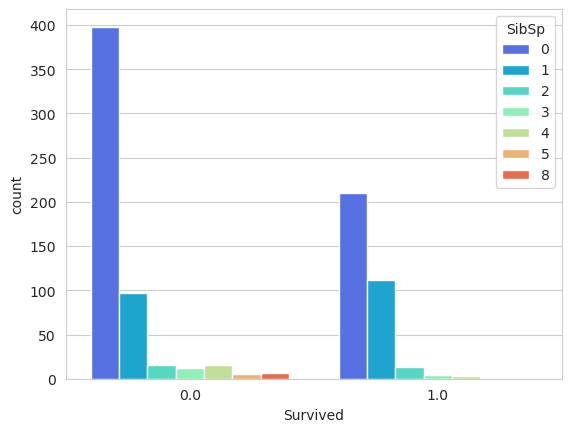

In [173]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='SibSp',data=train,palette='rainbow')

**How does the overall age distribution look like?**

<Axes: title={'center': 'Age histogram of the passengers'}, xlabel='Age of the passengers', ylabel='Count'>

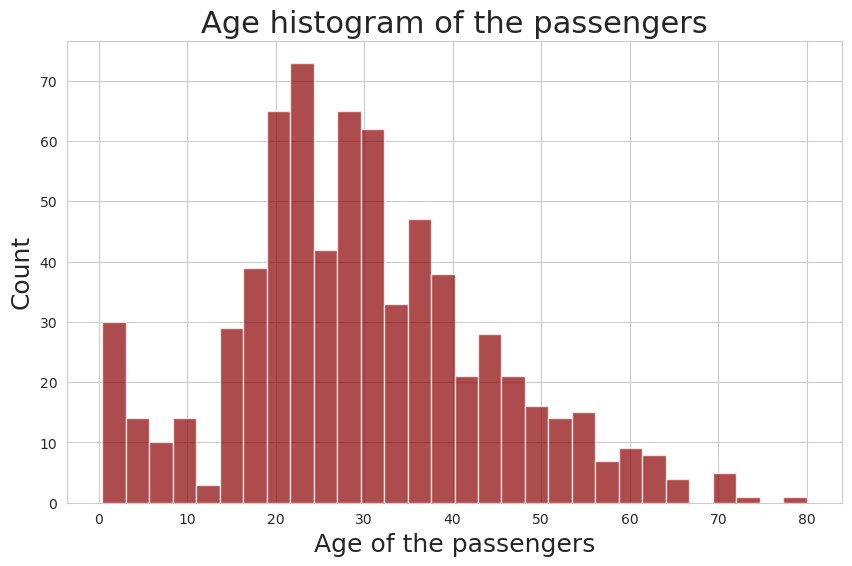

In [174]:
plt.xlabel("Age of the passengers",fontsize=18)
plt.ylabel("Count",fontsize=18)
plt.title("Age histogram of the passengers",fontsize=22)
train['Age'].hist(bins=30,color='darkred',alpha=0.7,figsize=(10,6))

**How does the age distribution look like across passenger class?**

It looks like that the average age is different for three classes and it generally decreases from 1st class to 3rd class.

<Axes: xlabel='Pclass', ylabel='Age'>

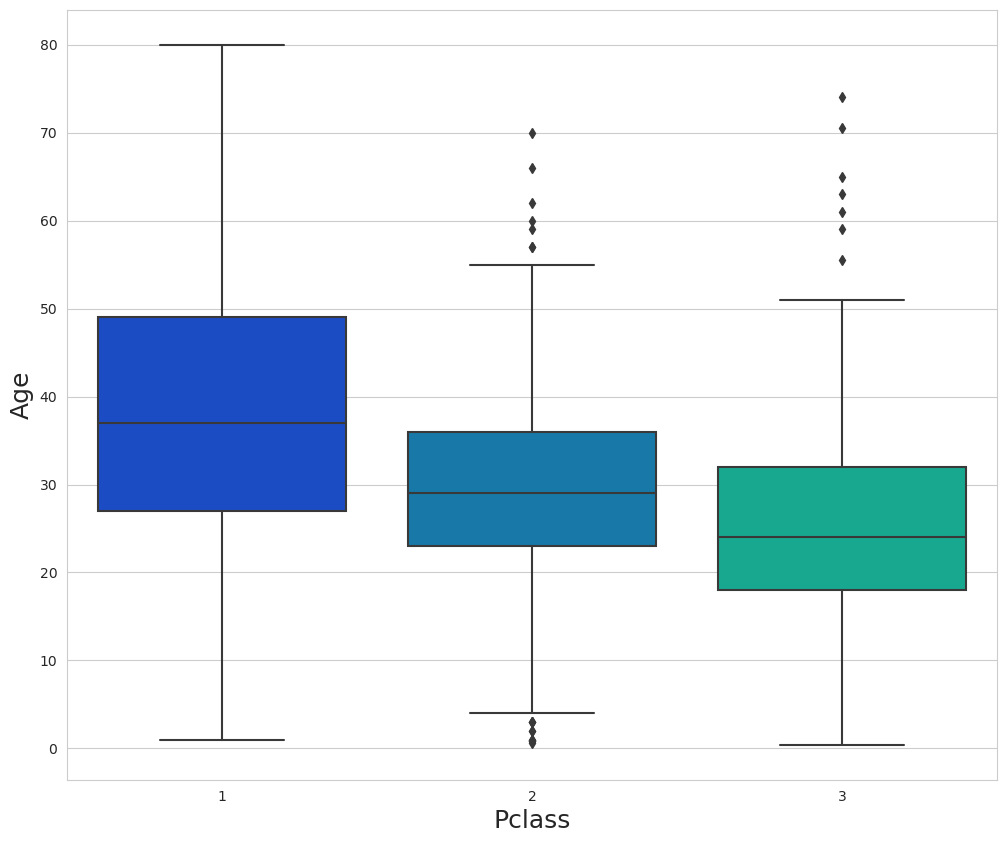

In [175]:
plt.figure(figsize=(12, 10))
plt.xlabel("Passenger Class",fontsize=18)
plt.ylabel("Age",fontsize=18)
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

Text(0.5, 0, 'Passenger class')

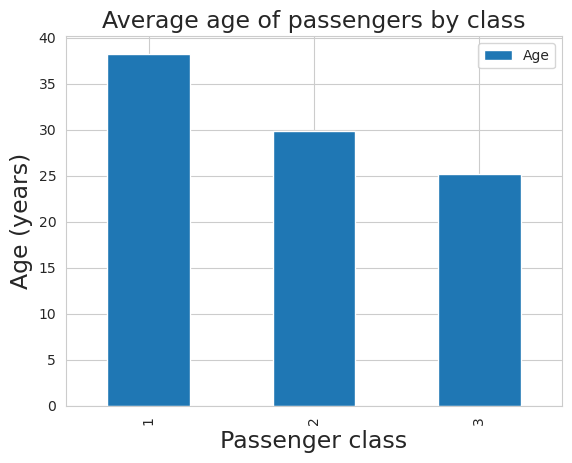

In [176]:
f_class_Age=train.groupby('Pclass')['Age'].mean()
f_class_Age = pd.DataFrame(f_class_Age)
f_class_Age.plot.bar(y='Age')
plt.title("Average age of passengers by class",fontsize=17)
plt.ylabel("Age (years)", fontsize=17)
plt.xlabel("Passenger class", fontsize=17)

## Data wrangling (impute and drop)
* Impute age (by averaging)
* Drop unncessary features
* Convert categorical features to dummy variables

### Define a function to impute (fill-up missing values) age feature

In [177]:
a=list(f_class_Age['Age'])

def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return a[0]
        elif Pclass == 2:
            return a[1]
        else:
            return a[2]
    else:
        return Age

**Apply the above-defined function and plot the count of numeric features**

Text(0.5, 1.0, 'Bar plot of the count of numeric features')

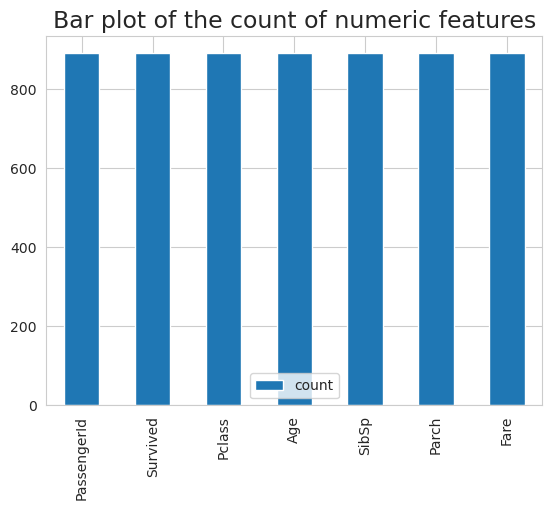

In [178]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)
d=train.describe()
dT=d.T
dT.plot.bar(y='count')
plt.title("Bar plot of the count of numeric features",fontsize=17)

### Exctracting extra features

Before start dropping NaN features I found that we could take some extra features, where some of them are based of features that are about to be droppend due to their high NaN count.

In [179]:
# hasCabin is a binary feature that says if the passanger had a Cabin or not
train['hasCabin'] = train['Cabin'].notna()

# hasFamiliar is a binary feature that says if the passanger had a familiar or not (from SibSp)
train['hasFamiliar'] = train['SibSp'] == 0

### Drop unnecessary features like 'PassengerId', 'Name', 'Ticket', 'Cabin' and any other null value

In [180]:
train.drop(['PassengerId','Name','Ticket', 'Cabin'],axis=1,inplace=True)
train.dropna(inplace=True)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,hasCabin,hasFamiliar
0,0.0,3,male,22.0,1,0,7.2500,S,False,False
1,1.0,1,female,38.0,1,0,71.2833,C,True,False
2,1.0,3,female,26.0,0,0,7.9250,S,False,True
3,1.0,1,female,35.0,1,0,53.1000,S,True,False
4,0.0,3,male,35.0,0,0,8.0500,S,False,True


### Convert categorial feature like 'Sex' and 'Embarked' to dummy variables and then drop the 'Sex' and 'Embarked' columns and concatenate the new dummy variables

**Use pandas 'get_dummies()' function**

In [181]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)
train.drop(['Sex','Embarked'],axis=1,inplace=True)
train = pd.concat([train,sex,embark],axis=1)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,hasCabin,hasFamiliar,male,Q,S
0,0.0,3,22.0,1,0,7.2500,False,False,True,False,True
1,1.0,1,38.0,1,0,71.2833,True,False,False,False,False
2,1.0,3,26.0,0,0,7.9250,False,True,False,False,True
3,1.0,1,35.0,1,0,53.1000,True,False,False,False,True
4,0.0,3,35.0,0,0,8.0500,False,True,True,False,True


In [182]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,hasCabin,hasFamiliar,male,Q,S
0,0.0,3,22.0,1,0,7.2500,False,False,True,False,True
1,1.0,1,38.0,1,0,71.2833,True,False,False,False,False
2,1.0,3,26.0,0,0,7.9250,False,True,False,False,True
3,1.0,1,35.0,1,0,53.1000,True,False,False,False,True
4,0.0,3,35.0,0,0,8.0500,False,True,True,False,True


This data set is now ready for any analysis!

Note 1: It would be a good idea to use StratifiedKFold when we are using Cross-Validation. The stratify has to be done in the funcion split_data and in cross_validation.

Note 2: La classe minoritaria, es decir la que tenga menos datos debe ser la classe 1.

## Polinomial features

As extra features we can add extra features which can help de model find any quadratic, cubic or basically polynomic correlation between certain features and the label, in this case we find usefull to use Numbered features such as Age and Fare.

In [183]:
from sklearn.preprocessing import PolynomialFeatures

def create_polynomial_features(data, columns, degree):
    # Copy the DataFrame
    data_copy = data.copy()

    poly = PolynomialFeatures(degree=degree, include_bias=False)

    for c in columns:
        # Select the specific column to apply polynomial features
        selected_data = data_copy[[c]]
        poly_data = poly.fit_transform(selected_data)

        # Create column names for the new polynomial features
        poly_column_names = [f"{c}_poly_{i}" for i in range(poly_data.shape[1])]
        print(poly_column_names)

        # Add the polynomial features to the DataFrame
        data_copy[poly_column_names] = poly_data

    # Drop the original columns that were transformed
    data_copy = data_copy.drop(columns=columns)

    return data_copy

train_sq = create_polynomial_features(train, ['Age', 'Fare'], 2)
train_sq.head()


['Age_poly_0', 'Age_poly_1']
['Fare_poly_0', 'Fare_poly_1']


,Survived,Pclass,SibSp,Parch,hasCabin,hasFamiliar,male,Q,S,Age_poly_0,Age_poly_1,Fare_poly_0,Fare_poly_1
0,0.0,3,1,0,False,False,True,False,True,22.0,484.0,7.2500,52.562500
1,1.0,1,1,0,True,False,False,False,False,38.0,1444.0,71.2833,5081.308859
2,1.0,3,0,0,False,True,False,False,True,26.0,676.0,7.9250,62.805625
3,1.0,1,1,0,True,False,False,False,True,35.0,1225.0,53.1000,2819.610000
4,0.0,3,0,0,False,True,True,False,True,35.0,1225.0,8.0500,64.802500


# Preprocessing Feature Selection

## Finding multicolineality:

In [184]:
correlation_matrix = train.corr()

# Trobar correlacions altes
highly_correlated = (correlation_matrix > 0.8) & (correlation_matrix < 1.0)
print(highly_correlated)

# TODO: Mirar si caldria com a extra buscar el "Variance Inflation Factor" (VIF) per la multicolineralitat, preguntar al prof

             Survived  Pclass    Age  SibSp  Parch   Fare  hasCabin  \
Survived        False   False  False  False  False  False     False   
Pclass          False   False  False  False  False  False     False   
Age             False   False  False  False  False  False     False   
SibSp           False   False  False  False  False  False     False   
Parch           False   False  False  False  False  False     False   
Fare            False   False  False  False  False  False     False   
hasCabin        False   False  False  False  False  False     False   
hasFamiliar     False   False  False  False  False  False     False   
male            False   False  False  False  False  False     False   
Q               False   False  False  False  False  False     False   
S               False   False  False  False  False  False     False   

             hasFamiliar   male      Q      S  
Survived           False  False  False  False  
Pclass             False  False  False  False  
Age

# Trobant Altes dimensions:

To detect high dimensions, we calculate the correlation matrix between the variables, computed in the previous cell. Variables with low or close-to-zero correlations can be considered high dimensions because they contain little relevant information. One of the indicators of the height of dimensions is the eigenspace of the correlation matrix.

In [185]:
# Càlcul dels autovectors i autovectors
eigenvalues, eigenvectors = np.linalg.eig(correlation_matrix)

# Trobar les dimensions amb baixes contribucions
explained_variance_ratio = eigenvalues / sum(eigenvalues)
print([[var, x] for var, x in zip(explained_variance_ratio, train.columns)])

[[0.24844799253367175, 'Survived'], [0.19991203621702247, 'Pclass'], [0.14894867969800404, 'Age'], [0.10540250755171451, 'SibSp'], [0.06810063601662966, 'Parch'], [0.06443679929617506, 'Fare'], [0.020894629505623468, 'hasCabin'], [0.024592728586433417, 'hasFamiliar'], [0.03490860604782744, 'male'], [0.04491888935024043, 'Q'], [0.03943649519665788, 'S']]


Here, as we can see, we obtain low correlation in attributes except for Pclass, Age, and SibSp. We will create a new dataframe with these variables that have a higher correlation.

In [186]:
cutted_train = train[['Survived', 'Pclass', 'Age', 'SibSp']]

## Aplicant PCA en tots les datasets

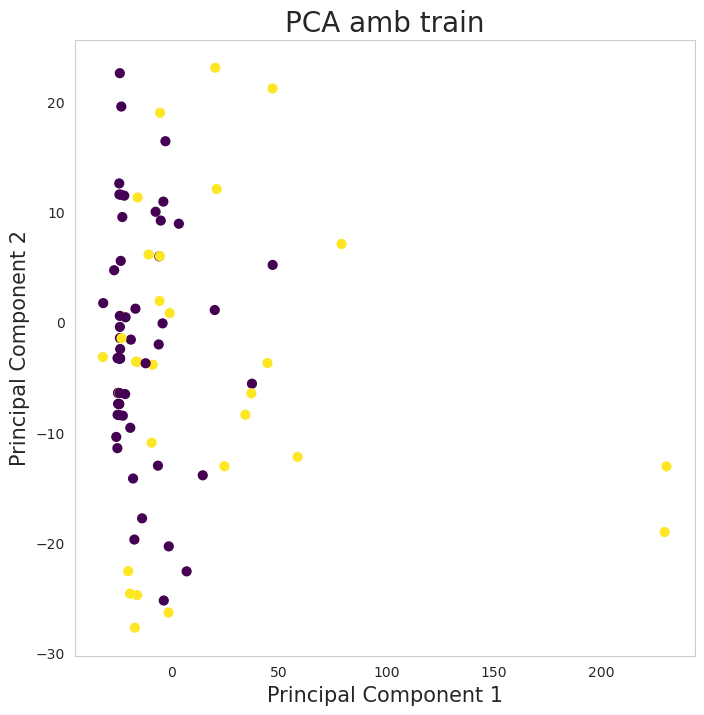

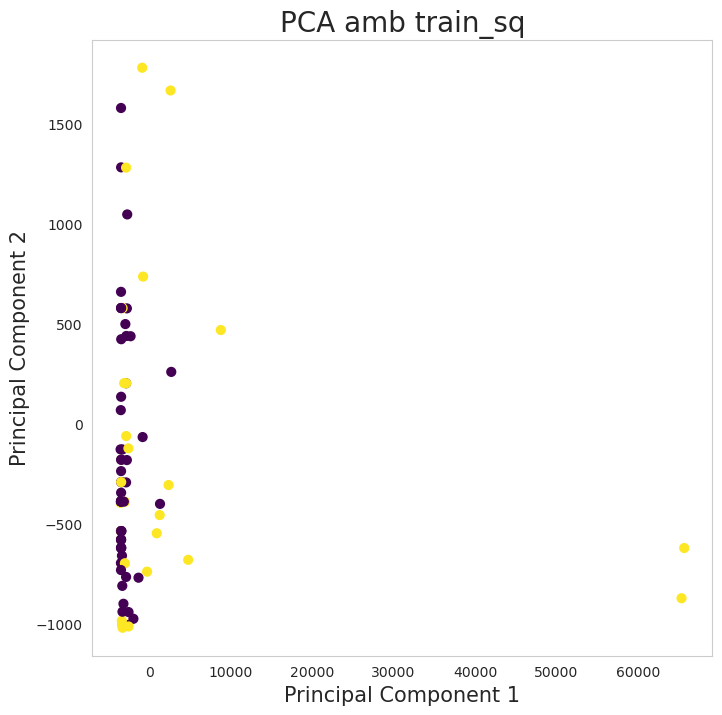

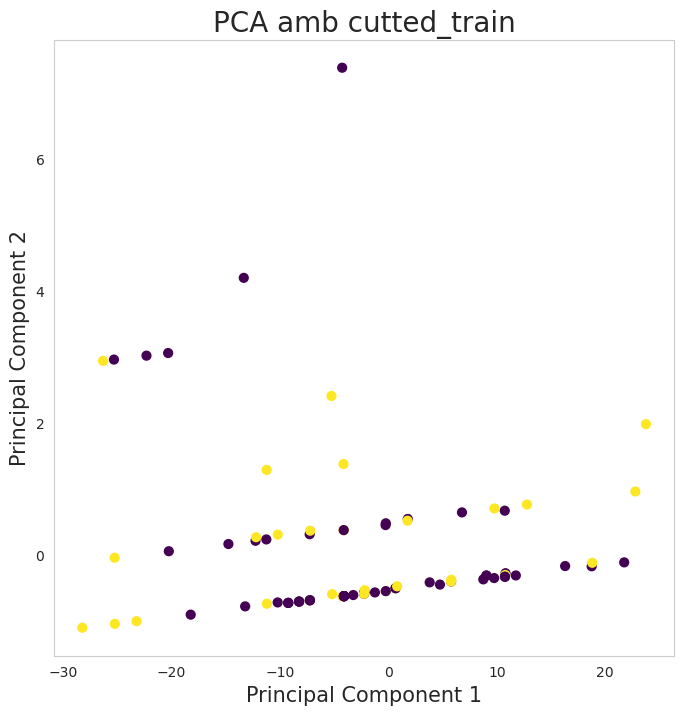

In [187]:
from sklearn.decomposition import PCA

def plot_PCA(x, y, components=2, title='2 component PCA'):
    pca = PCA(n_components=components)
    
    principalComponents = pca.fit_transform(x)
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title(title, fontsize = 20)
    
    ax.scatter(principalComponents[::10,0], principalComponents[::10,1],c = y[::10], s = 40, cmap='viridis')
    ax.grid()

plot_PCA(train.drop(columns=['Survived']), train['Survived'], title='PCA amb train')
plot_PCA(train_sq.drop(columns=['Survived']), train['Survived'], title='PCA amb train_sq')
plot_PCA(cutted_train.drop(columns=['Survived']), train['Survived'], title='PCA amb cutted_train')

As we can see, with PCA, we obtain principal components with fairly scattered points in the normal training dataset.

Meanwhile, with PCA squared, we no longer obtain normalized data because we have quadratic attributes that exaggerate the values we previously normalized, creating extreme cases like the last two that are around 60000.

Finally, with the dataset trimmed to those with higher linear correlation, we obtain principal components that even seem to have some correlation, although they are still scattered between one class and another.